**Setup Enviroment** 

In [2]:
import numpy as np
import os
import pandas as pd

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification,XLMRobertaTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")


**Load Data**


In [3]:
data=pd.read_excel("Merged _Fakenews_Data.xlsx")
data.head(10)

,Actual_Post,Label
0,መንግስት ከልምድ ተመሮ ምንም ጥቅምና አትኩሮት የሌለውን መግለጫ በመግለጫ...,Fake
1,ወይ ጉድ! ስለ ዜግነት በቅጡ ሳይረዱ ዜግነት ሰጪና ከልካይ የፖለቲካ መሪ...,Fake
2,አብሮነት በመከባበር ላይ የተመሰረተ መሆን አለበት። ኦሮሚያ ውስጥ የምትኖ...,Fake
3,እንኳን አሁን ወያኔም እያለ የህዝቦች ሁሉ ጠላት ነፍጠኛዉ ነው ብዬ ነበር...,Fake
4,"እንደዚህ እንደዚያ የሚያረጉን ""ኃይሎች"" እያሉ መንግስት ነን ባዮች ችግሮ...",Fake
5,እሺ ሰላማዊና ሚዘናዊ ዉይይታችንን ስንቀጥል፡ እዉነት እነዚህ የዜግነት ፖ...,Fake
6,የአማራ ድርጅቶች አብሮ ለመስራት መግባባታቸው ለበጎ ከሆነ እሰየው ነዉ። ...,Fake
7,እስኪ እንደው እንኹዋን #OMN ቀርቶ ለሰው ልጆች ሰላም፡ ፍትህና እኩልነ...,Fake
8,አይ አብይ አህመድ! መቸም ያንተን ታሪክ በቅርቡ እናያለን። በዓመታት የኦ...,Fake
9,ጊዜ የማይለዉጣቹ ሞኞች፡ አላዋቂዎችና አስመሳዮች (ለምሳሌ ዋናወቹ ታማኝና...,Fake


In [4]:
import nltk
import re

In [5]:
space_pattern = '\s+'
url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
englishword_num ='[a-zA-Z]|[0-9]+'
AmhPunc='[፤።፡፣:,.?/()•“”*፨]+'
special_char = "[፥@#$%^&=?×!,;:_.(){}`'+*<>\"¤—„\® ̄™¡¡\x10»€«·‘0e1b§”¬¦...""f÷\~ ̈©±¥£¶–°• ̃’“|]"
geez_number='[፩፪፫፬፭፮፯፰፱፲፳፴፵፶፷፸፹፺፻] ' # for removing geez number
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                 u"\U0001F1E0-\U0001F1FF"  # flags 
                                 u"\U00002702-\U000027B0"
                                 u"\U000024C2-\U0001F251"
                                 "]+", flags=re.UNICODE)
haa='[ሃ]'; he='[ሐ]'; hu='[ሑ]'; hi='[ሒ]'; ha='[ሓ]'; hie='[ሔ]'; h='[ሕ]'; ho='[ሖ]'; he1='[ኀ]'; hu1='[ኁ]'; hi1='[ኂ]'; ha1='[ኃ]'; hie1='[ኄ]'; h1='[ኅ]'; ho1='[ኆ]';
se='[ሠ]'; su='[ሡ]'; si='[ሢ]'; sa='[ሣ]'; sie='[ሤ]'; s='[ሥ]'; so='[ሦ]'; 
aa1='[ኣ]'; ae='[ዐ]'; au='[ዑ]'; ai='[ዒ]'; aa='[ዓ]'; aie='[ዔ]'; e='[ዕ]'; ao='[ዖ]';
tse='[ጸ]'; tsu='[ጹ]'; tsi='[ጺ]'; tsa='[ጻ]'; tsie='[ጼ]'; ts='[ጽ]'; tso='[ጾ]';

In [6]:
corpus=[]
for i in range(0,len(data)):
    Clean_text = re.sub(url_regex,'', str(data['Actual_Post'][i]))
    Clean_text = re.sub(AmhPunc,' ',Clean_text)
    Clean_text=re.sub(special_char,' ',Clean_text)
    Clean_text= re.sub(englishword_num,'',Clean_text)
    Clean_text= re.sub(r'(.)\1+', r'\1\1',Clean_text) #removingelongation in text
    Clean_text = RE_EMOJI.sub(r'', Clean_text)
    Clean_text =re.sub(geez_number,'',Clean_text)
    Clean_text=re.sub('-','',Clean_text)
    Clean_text=re.sub(r'<[^>]*>','', Clean_text)
    Clean_text = Clean_text.replace("\\", "");
    Clean_text = Clean_text.replace("[", "");
    Clean_text = Clean_text.replace("]", "");
    Clean_text = emoji_pattern.sub(r'', Clean_text)
    Clean_text = re.sub(space_pattern,' ',Clean_text)
    ##################################################
    Clean_text= re.sub(he,'ሀ',Clean_text); 
    Clean_text= re.sub(hu,'ሁ',Clean_text);
    Clean_text= re.sub(hi,'ሂ',Clean_text);
    Clean_text= re.sub(ha,'ሀ',Clean_text); 
    Clean_text= re.sub(hie,'ሄ',Clean_text);
    Clean_text= re.sub(h,'ህ',Clean_text);
    Clean_text= re.sub(ho,'ሆ',Clean_text);
    Clean_text= re.sub(haa,'ሀ',Clean_text);
    #######################################################
    Clean_text= re.sub(he1,'ሀ',Clean_text) 
    Clean_text= re.sub(hu1,'ሁ',Clean_text) 
    Clean_text= re.sub(hi1,'ሂ',Clean_text)
    Clean_text= re.sub(ha1,'ሀ',Clean_text)
    Clean_text= re.sub(hie1,'ሄ',Clean_text)
    Clean_text= re.sub(h1,'ህ',Clean_text)
    Clean_text= re.sub(ho1,'ሆ',Clean_text)
    ##########################################################
    Clean_text= re.sub(se,'ሰ',Clean_text) 
    Clean_text= re.sub(su,'ሱ',Clean_text)
    Clean_text= re.sub(si,'ሲ',Clean_text)
    Clean_text= re.sub(sa,'ሳ',Clean_text)
    Clean_text= re.sub(sie,'ሴ',Clean_text) 
    Clean_text= re.sub(s,'ስ', Clean_text)
    Clean_text= re.sub(so,'ሶ',Clean_text)
    ###################################################
    Clean_text= re.sub(ae,'አ',Clean_text) 
    Clean_text= re.sub(au,'ኡ',Clean_text)
    Clean_text= re.sub(ai,'ኢ',Clean_text)
    Clean_text= re.sub(aa,'አ',Clean_text) 
    Clean_text= re.sub(aie,'ኤ',Clean_text)
    Clean_text= re.sub(e,'እ',Clean_text)
    Clean_text= re.sub(ao,'ኦ',Clean_text)
    Clean_text= re.sub(aa1,'አ',Clean_text)
    #############################################
    Clean_text= re.sub(tse,'ፀ',Clean_text) 
    Clean_text= re.sub(tsu,'ፁ',Clean_text) 
    Clean_text= re.sub(tsi,'ፂ',Clean_text)
    Clean_text= re.sub(tsa,'ፃ',Clean_text) 
    Clean_text= re.sub(tsie,'ፄ',Clean_text)
    Clean_text= re.sub(ts,'ፅ',Clean_text)
    Clean_text= re.sub(tso,'ፆ',Clean_text)
    Clean_text= Clean_text.split()
    Clean_text = ' '.join(Clean_text)
    corpus.append(Clean_text)

In [7]:
data.head(10)

,Actual_Post,Label
0,መንግስት ከልምድ ተመሮ ምንም ጥቅምና አትኩሮት የሌለውን መግለጫ በመግለጫ...,Fake
1,ወይ ጉድ! ስለ ዜግነት በቅጡ ሳይረዱ ዜግነት ሰጪና ከልካይ የፖለቲካ መሪ...,Fake
2,አብሮነት በመከባበር ላይ የተመሰረተ መሆን አለበት። ኦሮሚያ ውስጥ የምትኖ...,Fake
3,እንኳን አሁን ወያኔም እያለ የህዝቦች ሁሉ ጠላት ነፍጠኛዉ ነው ብዬ ነበር...,Fake
4,"እንደዚህ እንደዚያ የሚያረጉን ""ኃይሎች"" እያሉ መንግስት ነን ባዮች ችግሮ...",Fake
5,እሺ ሰላማዊና ሚዘናዊ ዉይይታችንን ስንቀጥል፡ እዉነት እነዚህ የዜግነት ፖ...,Fake
6,የአማራ ድርጅቶች አብሮ ለመስራት መግባባታቸው ለበጎ ከሆነ እሰየው ነዉ። ...,Fake
7,እስኪ እንደው እንኹዋን #OMN ቀርቶ ለሰው ልጆች ሰላም፡ ፍትህና እኩልነ...,Fake
8,አይ አብይ አህመድ! መቸም ያንተን ታሪክ በቅርቡ እናያለን። በዓመታት የኦ...,Fake
9,ጊዜ የማይለዉጣቹ ሞኞች፡ አላዋቂዎችና አስመሳዮች (ለምሳሌ ዋናወቹ ታማኝና...,Fake


In [8]:
# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1) 
data['Label'] = pd.get_dummies(data.Label)['Fake']

([<matplotlib.patches.Wedge at 0x2201bd40820>,
 [Text(-1.19865650779119, 0.05676774022126825, 'Fake'),
  Text(1.1986565024762053, -0.05676785244758921, 'Real')],
 [Text(-0.6992162962115274, 0.033114515129073145, '48.5%'),
  Text(0.6992162931111197, -0.03311458059442703, '51.5%')])

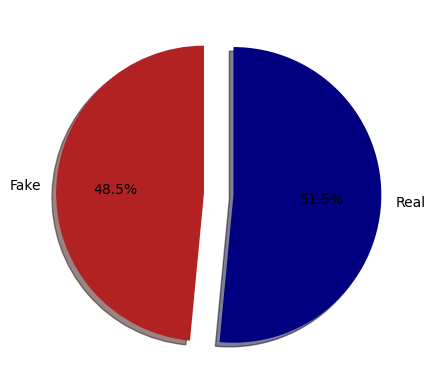

In [9]:
# Checking if our data is well balanced
label_size = [data['Label'].sum(),len(data['Label'])- data['Label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','Real'],autopct='%1.1f%%')

In [10]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['Actual_Post'], data['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=data['Label'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

**AfriBERTa Fine Tunning**

In [11]:
from transformers import XLMRobertaModel, XLMRobertaTokenizer,AutoTokenizer, AutoModelForTokenClassification

In [12]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = XLMRobertaModel.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')


Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Tokenize text Data

Text(0, 0.5, 'Number of texts')

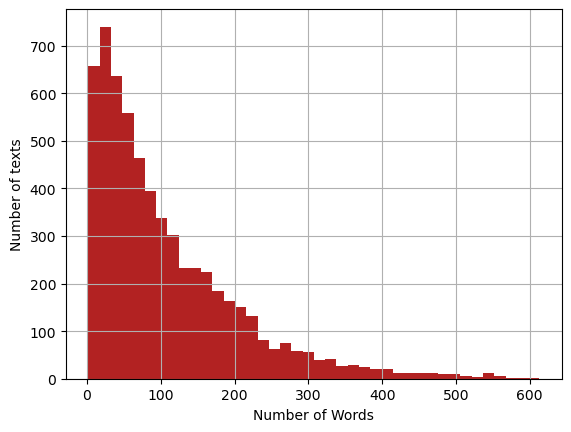

In [13]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(Actual_Post.split()) for Actual_Post in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [14]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

C:\Users\MenbiAmel\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2137: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [16]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [17]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [18]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 10

In [19]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [20]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'XML-R new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    189.

Evaluating...

Training Loss: 0.694
Validation Loss: 0.693

 Epoch 2 / 10
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    189.

Evaluating...

Training Loss: 0.692
Validation Loss: 0.692

 Epoch 3 / 10
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    189.

Evaluating...

Training Loss: 0.692
Validation Loss: 0.692

 Epoch 4 / 10
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    189.

Evaluating...

Training Loss: 0.692
Validation Loss: 0.691

 Epoch 5 / 10
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    189.

Evaluating...

Training Loss: 0.692
Validation Loss: 0.691

 Epoch 6 / 10
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    189.

Evaluating...

Training Loss: 0.691
Validation Loss: 0.692

 Epoch 7 / 10
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  

In [21]:
# load weights of best model
path = 'XML-R new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [22]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.57      0.95      0.71       667
           1       0.82      0.25      0.39       628

    accuracy                           0.61      1295
   macro avg       0.69      0.60      0.55      1295
weighted avg       0.69      0.61      0.56      1295

